# Annotating cell types
This tutorial is to familiarize users with SCimilarity's basic cell annotation functionality.

System requirements:

  - At least 64GB of RAM

## 0. Required software and data
Things you need for this demo:

 0. [SCimilarity](https://github.com/Genentech/scimilarity) package should already be installed.

 1. SCimilarity trained model. [Download SCimilarity models](https://zenodo.org/record/8240464). Note, this is a large tarball - downloading and uncompressing can take a several minutes.

 2. A dataset to annotate. We will use [Adams et al., 2020](https://www.science.org/doi/10.1126/sciadv.aba1983?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) healthy and IPF lung scRNA-seq data. [Download tutorial data](https://zenodo.org/records/13685881).

If the model hasn't been downloaded please uncomment and run the two command below

In [1]:
# !curl -L -o /models/model_v1.1.tar.gz \
#   https://zenodo.org/records/10685499/files/model_v1.1.tar.gz?download=1
# !tar -xzvf /models/model_v1.1.tar.gz

If the data hasn't been downloaded please uncomment and run the two command below

In [2]:
# !curl -L -o "/data/GSE136831_subsample.h5ad" \
#   https://zenodo.org/records/13685881/files/GSE136831_subsample.h5ad?download=1

In [3]:
import scanpy as sc
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
sc.set_figure_params(dpi=100)
sc.settings.verbosity = 0
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["pdf.fonttype"] = 42
from scimilarity import CellAnnotation
from scimilarity.utils import align_dataset, lognorm_counts

## 1. Prepare for SCimilarity: Import and normalize data

In [5]:
# Instantiate the CellAnnotation object
# Set model_path to the location of the uncompressed model
model_path = "/models/model_v1.1"
ca = CellAnnotation(model_path=model_path)

### Load scRNA-seq data

In [6]:
# Load the tutorial data
# Set data_path to the location of the tutorial dataset
data_path = "/data/GSE136831_subsample.h5ad"
adams = sc.read(data_path)

### SCimilarity pre-processing
SCimilarity requires new data to be processed in a specific way that matches how the model was trained. 

#### Match feature space with SCimilarity models 
SCimilarity's gene expression ordering is fixed. New data should be reorderd to match that, so that it is consistent with how the model was trained. Genes that are not present in the new data will be zero filled to comply to the expected structure. Genes that are not present in SCimilarity's gene ordering will be filtered out. 

Note, SCimilarity was trained with high data dropout to increase robustness to differences in gene lists. 

In [7]:
adams = align_dataset(adams, ca.gene_order)

#### Normalize data consistent with SCimilarity
It is important to match Scimilarity's normalization so that the data matches the lognorm tp10k procedure used during model training.

In [8]:
adams = lognorm_counts(adams)

With these simple steps, the data is now ready for SCimilarity. We are able to filter cells whenever we want (even after embedding) because SCimilarity handles each cell independently and can skip highly variable gene selection altogether.

## 2. Compute embeddings
Using the already trained model, SCimilarity can embed your new dataset. 

In [9]:
adams.obsm["X_scimilarity"] = ca.get_embeddings(adams.X)

### Compute visualization of embeddings
#### Use UMAP to visualize SCimilarity embeddings

In [10]:
sc.pp.neighbors(adams, use_rep="X_scimilarity")
sc.tl.umap(adams)

### Visualize author annotations on the SCimilarity embedding

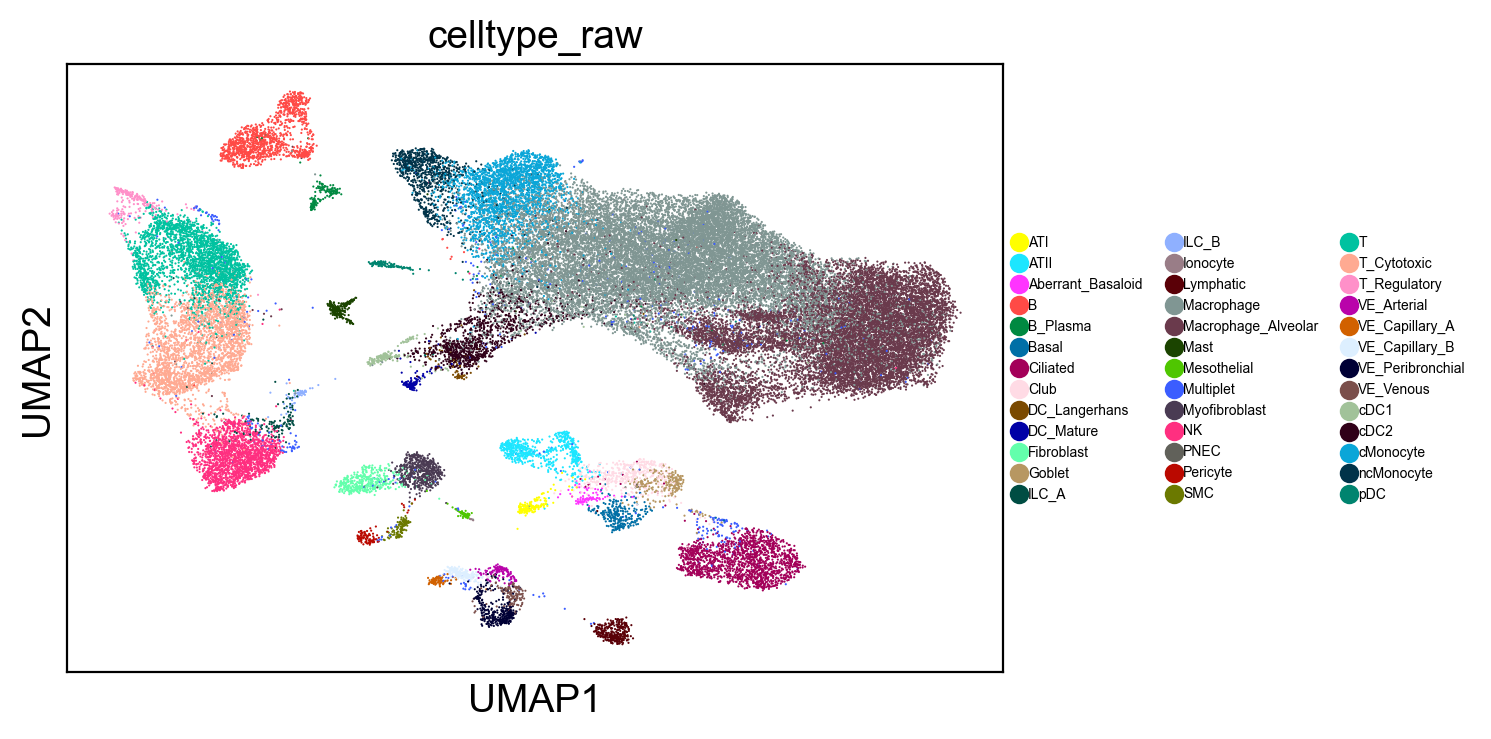

<Figure size 600x400 with 0 Axes>

In [11]:
sc.pl.umap(adams, color="celltype_raw", legend_fontsize=5)
plt.savefig("adams_umap.png", dpi=300, bbox_inches="tight")

Given that author annotations are derived from a different analysis, seeing author annotations roughly cluster in SCimilarity embedding space gives us confidence in our representation. The Adams et al. dataset was not included in the training set, meaning that this is the first time the model has seen this data, yet it is still able to represent the cells present.

## 3. Cell type classification

Two methods within the CellAnnotation class:
 1. `annotate_dataset` - automatically computes embeddings.
 2. `get_predictions_knn` - more detailed control of annotation.

h *Description of inputs*
 - `X_scimilarity`: embeddings from the model, which can be used to generate UMAPs in lieu of PCA and is generalized across datasets.   

*Description of outputs*
 - `predictions`: cell type annotation predictions.
 - `nn_idxs`: indicies of cells in the SCimilarity reference. 
 - `nn_dists`: the minimum distance within k=50 nearest neighbors.
 - `nn_stats`: a dataframe containing useful metrics such as: 
 - `hits`: the distribution of celltypes in k=50 nearest neighbors.

### Unconstrained annotation
Cells can be classified as any type that is in the SCimilarity reference 

In [12]:
predictions, nn_idxs, nn_dists, nn_stats = ca.get_predictions_knn(
    adams.obsm["X_scimilarity"], weighting=True
)
adams.obs["predictions_unconstrained"] = predictions.values

Get nearest neighbors finished in: 0.0311508576075236 min


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:20<00:00, 2387.48it/s]


Since each cell is classified independently, there is higher classification noise, filtering out low count cells can reduce the noise in visualization.

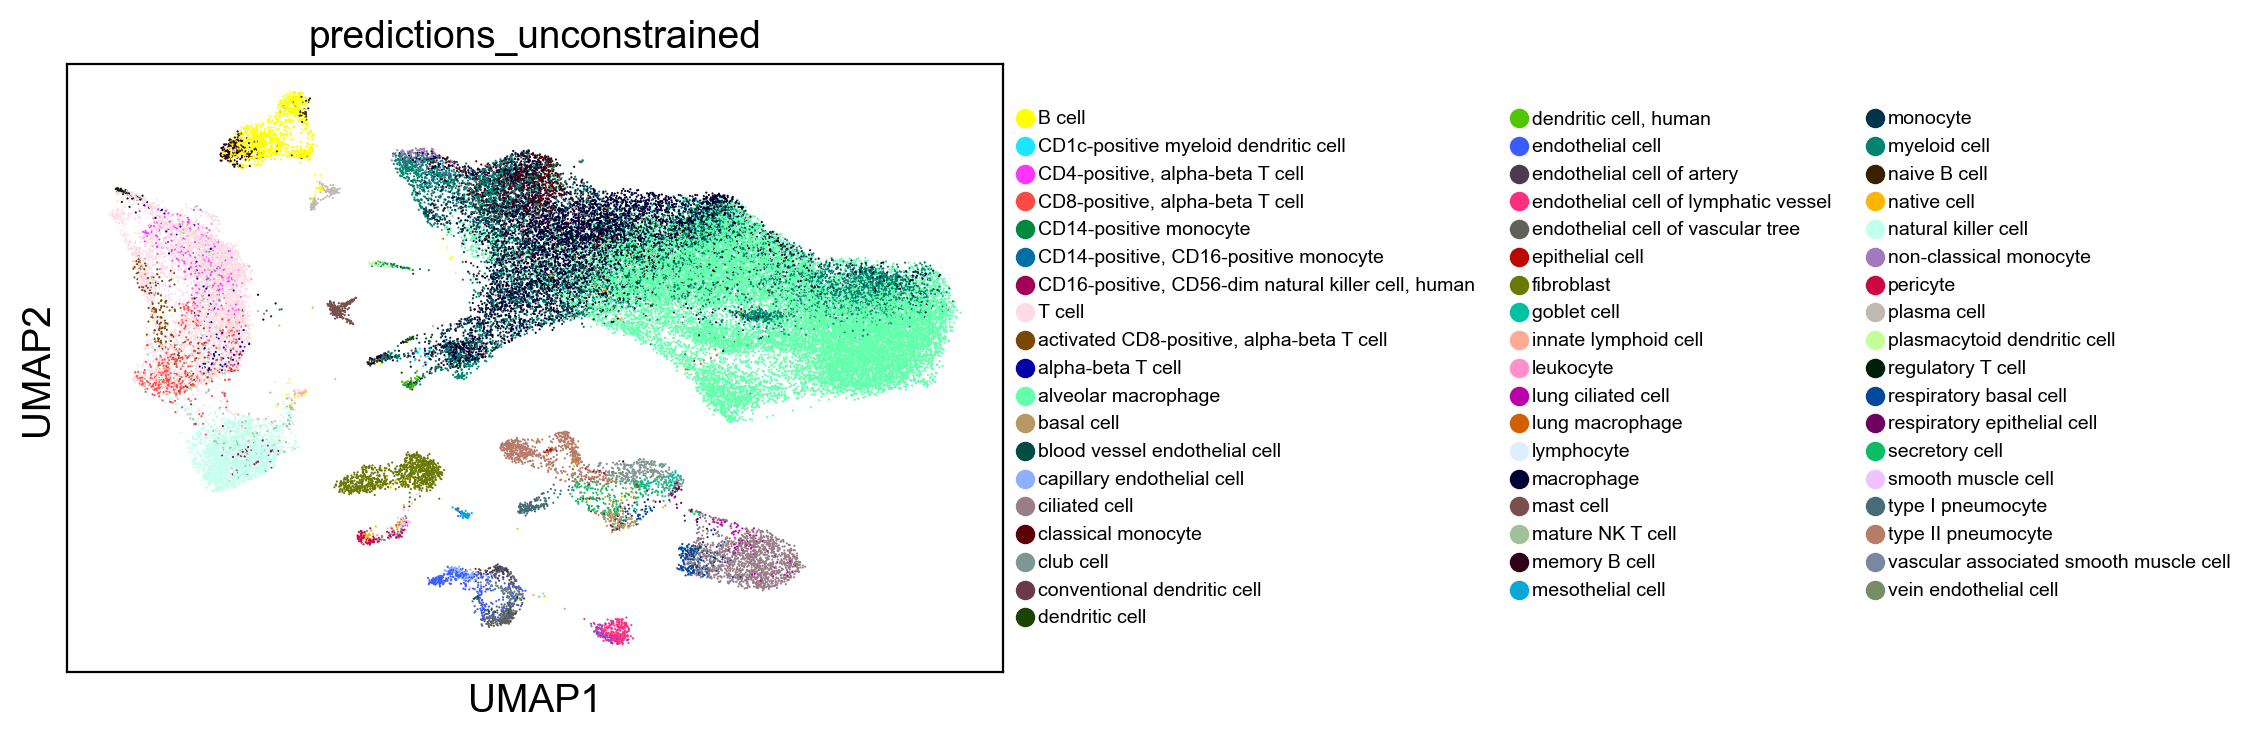

In [13]:
celltype_counts = adams.obs.predictions_unconstrained.value_counts()
well_represented_celltypes = celltype_counts[celltype_counts > 20].index

sc.pl.umap(
    adams[adams.obs.predictions_unconstrained.isin(well_represented_celltypes)],
    color="predictions_unconstrained",
    legend_fontsize=7,
)

### Constrained classification
By classifying against the full reference, we can get redundant cell types, such as activated CD8-positive, alpha-beta T cell and CD8-positive, alpha-beta T cell.

Alternatively, we can subset the reference to just the cell types we want to classify to. This also reduces noise in cell type annotation.

Note that subsetting can slow classification speeds as the kNN is optimized for the full reference.

In [14]:
# We can load all the labels from the model to finetune the labels that we would like to safelist 
print("\n".join(ca.classes))

capillary endothelial cell
retinal bipolar neuron
club cell
melanocyte
plasmacytoid dendritic cell
duct epithelial cell
kidney collecting duct principal cell
precursor B cell
luminal cell of prostate epithelium
erythroid lineage cell
inflammatory macrophage
type I pneumocyte
CD14-low, CD16-positive monocyte
neural crest cell
platelet
keratinocyte
oligodendrocyte precursor cell
activated CD4-positive, alpha-beta T cell
double-positive, alpha-beta thymocyte
IgG plasma cell
neural cell
amacrine cell
lymphocyte
pericyte
natural killer cell
CD4-positive, alpha-beta memory T cell
pulmonary ionocyte
CD141-positive myeloid dendritic cell
cholangiocyte
mature NK T cell
enteroendocrine cell
pancreatic ductal cell
regulatory T cell
effector memory CD8-positive, alpha-beta T cell, terminally differentiated
group 3 innate lymphoid cell
blood vessel endothelial cell
dendritic cell, human
vascular associated smooth muscle cell
double negative thymocyte
basal cell
kidney collecting duct intercalated c

In [15]:
# We will select labels that are relevant to the lung dataset (using our knowledge of the dataset).
# Every user can make their own decision on what labels to safelist depending on the dataset they are analyzing

target_celltypes = [
    "lung macrophage",
    "alveolar macrophage",
    "classical monocyte",
    "non-classical monocyte",
    "conventional dendritic cell",
    "plasmacytoid dendritic cell",
    "mast cell",
    "CD4-positive, alpha-beta T cell",
    "regulatory T cell",
    "CD8-positive, alpha-beta T cell",
    "mature NK T cell",
    "natural killer cell",
    "B cell",
    "plasma cell",
    "type I pneumocyte",
    "type II pneumocyte",
    "club cell",
    "goblet cell",
    "lung ciliated cell",
    "basal cell",
    "respiratory basal cell",
    "secretory cell",
    "neuroendocrine cell",
    "pulmonary ionocyte",
    "endothelial cell of vascular tree",
    "endothelial cell of lymphatic vessel",
    "pericyte",
    "vascular associated smooth muscle cell",
    "fibroblast",
    "myofibroblast cell",
]

ca.safelist_celltypes(target_celltypes)

In [16]:
# The ca.annotate_dataset function will now only classify to the safelisted cell types
adams = ca.annotate_dataset(adams)

Get nearest neighbors finished in: 0.09163140455881755 min


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:19<00:00, 2578.92it/s]


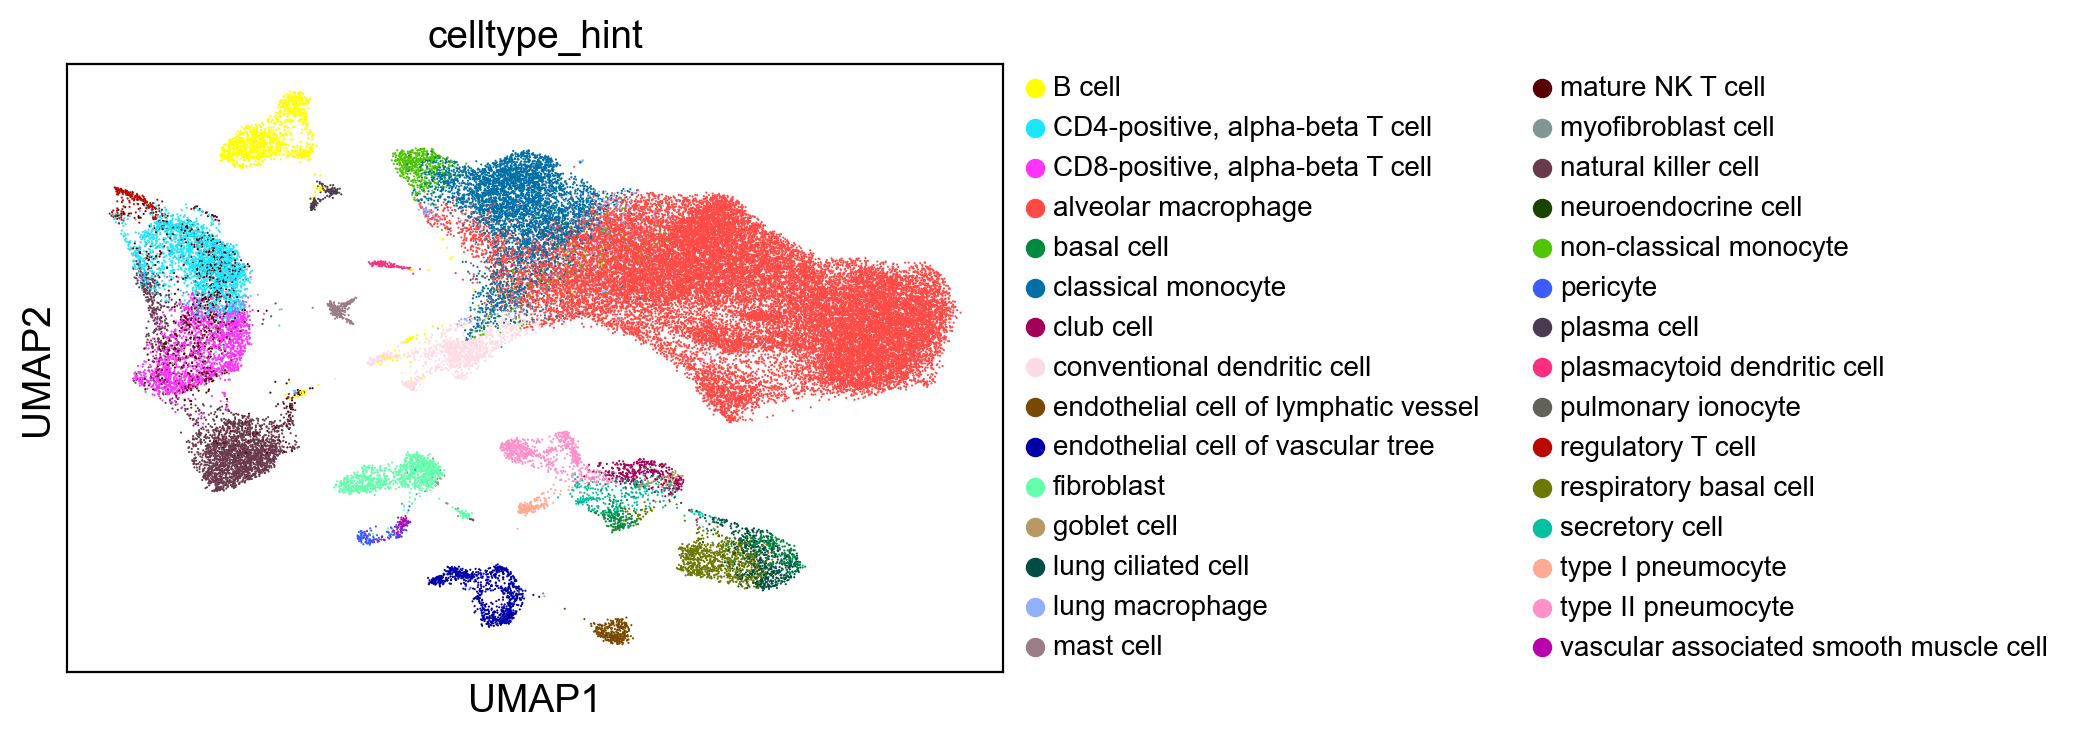

In [17]:
sc.pl.umap(adams, color="celltype_hint", legend_fontsize=10)

### Annotation QC
Cell annotation also computes QC metrics for our annotations. One of which, `min_dist`, represents the minimum distance between a cell in the query dataset and all cells in the training set. The greater `min_dist`, (i.e., the further away from what the model has seen before) the less confidence we have in the model's prediction. 

Note that for different applications and questions different `min_dist` ranges have different implications.

The model was trained to push the distance between dissimilar cells (i.e. positive and negative cells in each triplet) to > 0.05 (which is the default margin parameter of the triplet loss function). Distances larger than 0.05 particularly indicate that the model is not confident in the prediction. 

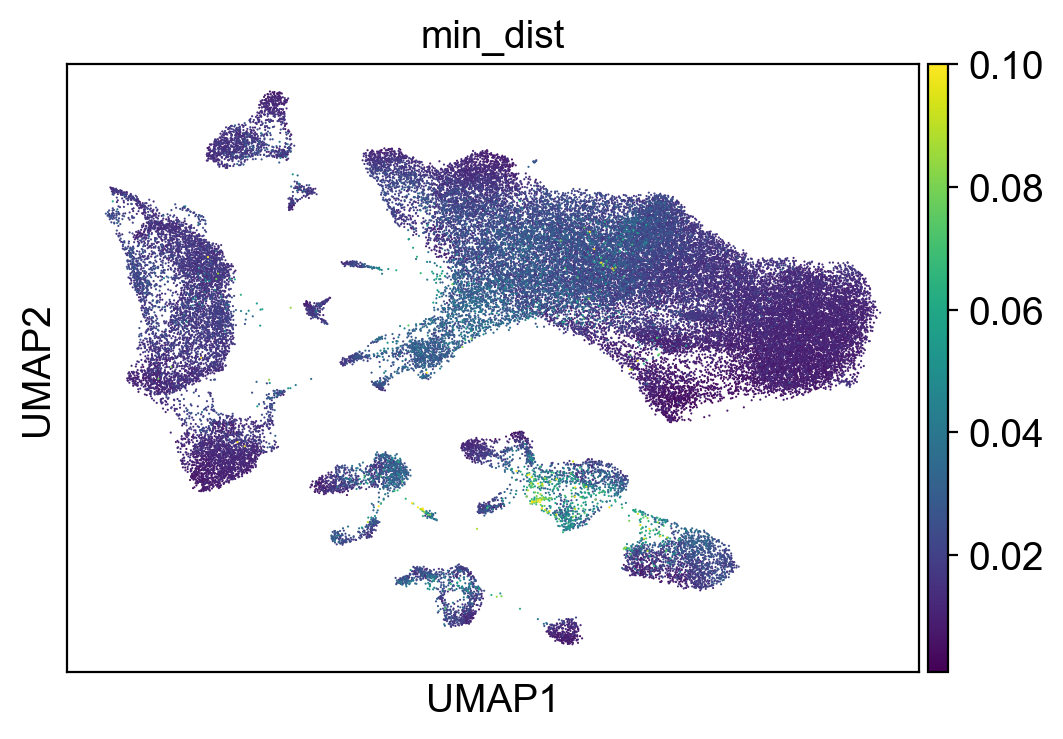

<Figure size 600x400 with 0 Axes>

In [18]:
sc.pl.umap(adams, color="min_dist", vmax=0.1)
plt.savefig("adams_umap_min_dist.png", dpi=300, bbox_inches="tight")

## Alternative method for annotation (cluster consensus annotation)
An alternative way of performing annotation is to cluster the cells based on the SCimilarity embeddings then 
use the clusters to predict a single cell type for each cluster. This method is sensitive to the choice of cluster resolution 
and users are advised to experiment with different resolutions and make sure their clusters are stable and fairly homogenous.

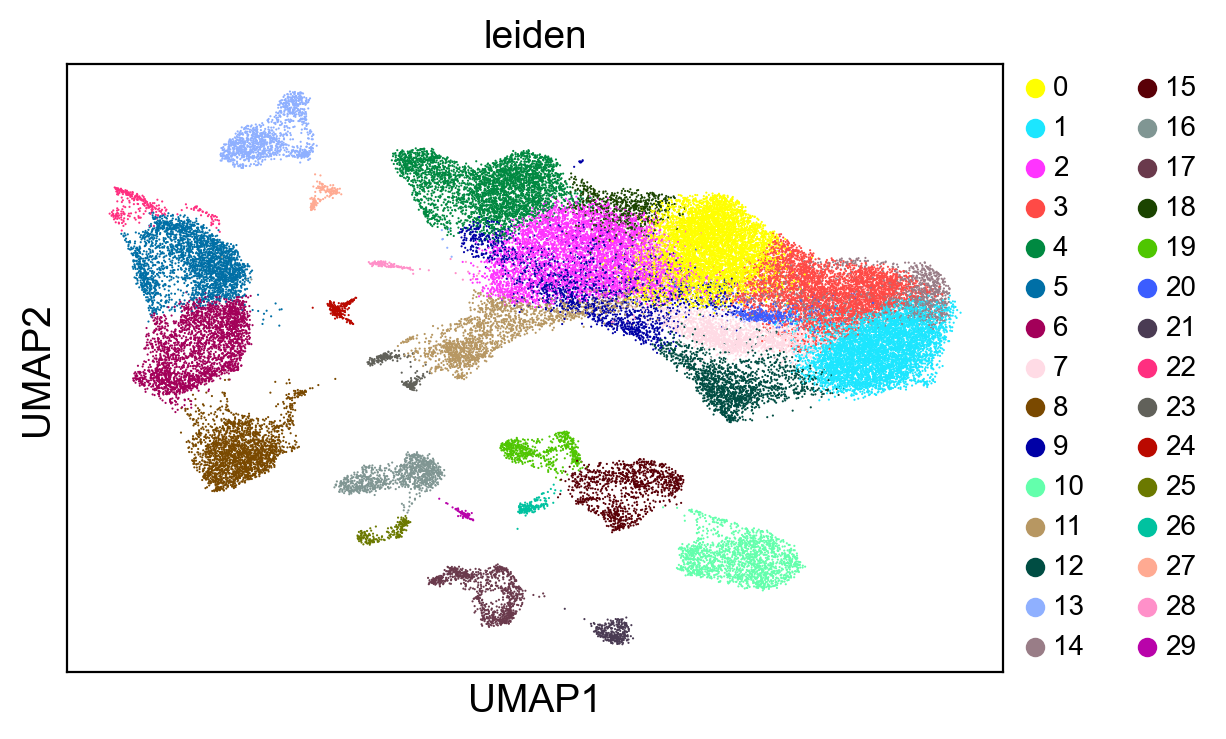

In [19]:
sc.tl.leiden(adams, resolution=1)
sc.pl.umap(adams, color="leiden", legend_fontsize=10)

In [20]:
# Create leiden-based annotation by picking the most common celltype_hint for each cluster
leiden_based_annotation = {}

# Loop through each unique cluster
for cluster in adams.obs['leiden'].unique():
    # Get all cells in this cluster
    cluster_mask = adams.obs['leiden'] == cluster
    cluster_celltypes = adams.obs.loc[cluster_mask, 'celltype_hint']
    
    # Find the most common celltype in this cluster
    most_common_celltype = cluster_celltypes.value_counts().index[0]
    leiden_based_annotation[cluster] = most_common_celltype

# Map the cluster-based annotations to all cells
adams.obs['leiden_based_annotation'] = adams.obs['leiden'].map(leiden_based_annotation)

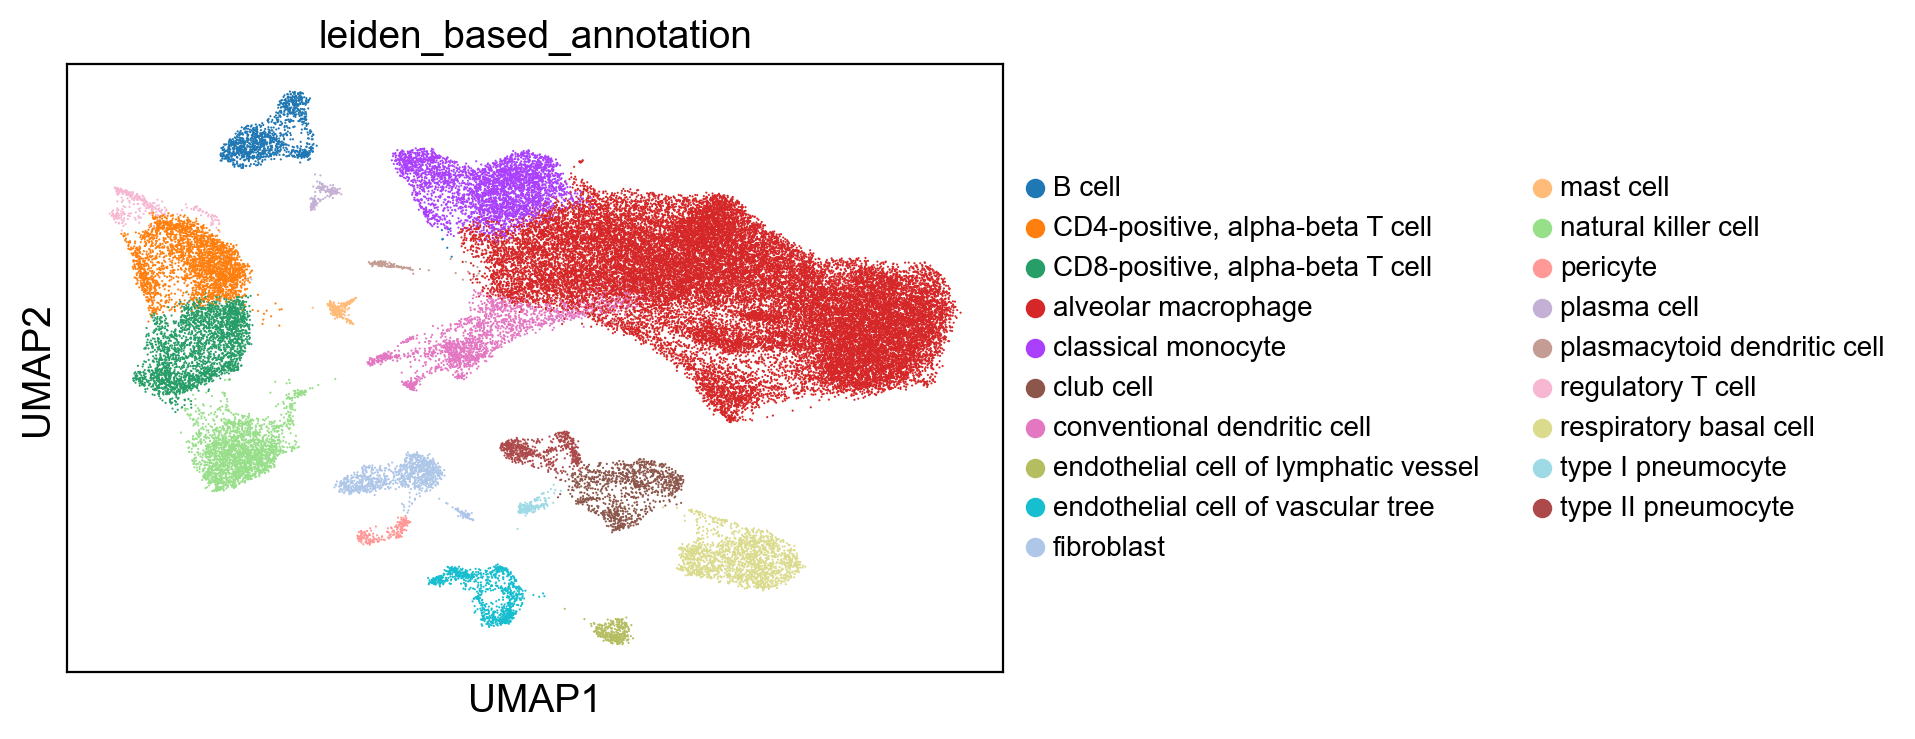

In [21]:
# Plot the leiden-based annotation on UMAP
sc.pl.umap(adams, color='leiden_based_annotation', legend_fontsize=10)

We can also visualize the labels within each cluster to troubleshoot some of the problematic clusters

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cluster_label_bars(
    adata,
    cluster_col,
    label_col,
    max_cols=5,
    output_file=None,
    title="Label Counts per Cluster"
):
    unique_clusters = sorted(adata.obs[cluster_col].unique(), key=lambda x: int(x) if str(x).isdigit() else str(x))
    n_clusters = len(unique_clusters)
    n_cols = min(max_cols, n_clusters)
    n_rows = int(np.ceil(n_clusters / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 4.5 * n_rows), squeeze=True)

    for idx, cluster in enumerate(unique_clusters):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        mask = adata.obs[cluster_col] == cluster
        cluster_labels = adata.obs.loc[mask, label_col]
        label_names, counts = np.unique(cluster_labels, return_counts=True)
        ax.bar(label_names, counts)
        ax.set_title(f"Cluster {cluster}")
        ax.set_ylabel("Count")
        ax.set_xticks(range(len(label_names)))
        ax.set_xticklabels(label_names, rotation=45, ha="right", fontsize=10)
        ax.margins(y=0.2)

    for idx in range(n_clusters, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col])

    fig.suptitle(title, fontsize=20)
    fig.tight_layout(rect=(0, 0, 1, 0.95))
    fig.subplots_adjust(wspace=0.5, hspace=0.8)
    if output_file:
        fig.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close(fig)

    return fig

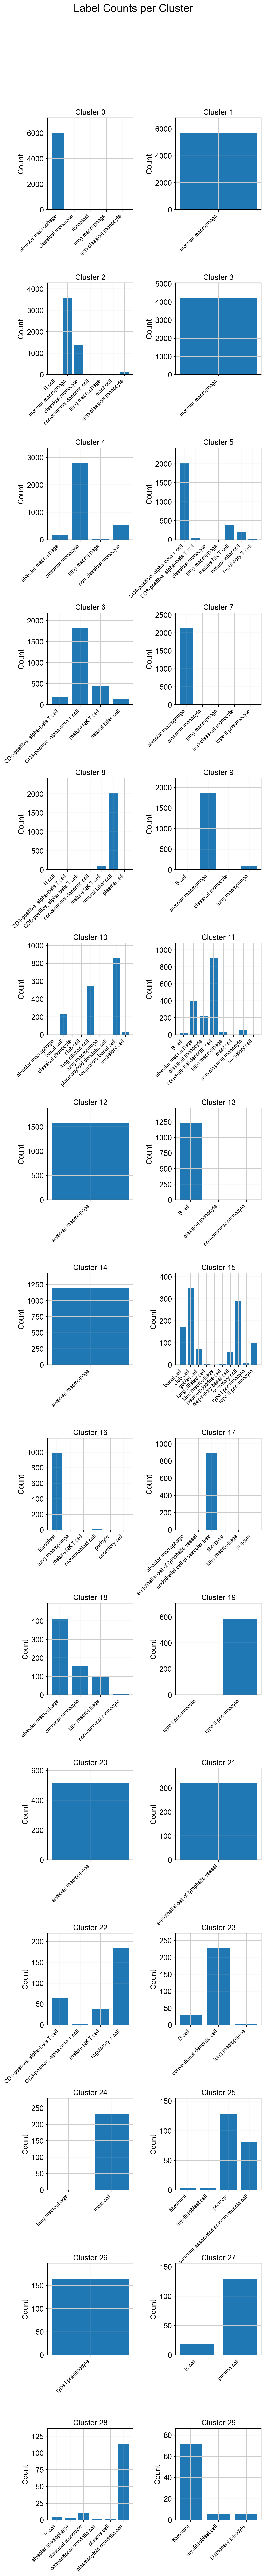

In [23]:
plot_cluster_label_bars(adams, "leiden", "celltype_hint", max_cols=2, output_file="adams_cluster_label_bars.png")

We can see that some of the clusters have more than a single type. It's up to the users to decide if they are happy with picking the most common label or if they would like to look at these clusters in more detail i.e. subcluster them, plot some canonical gene markers, etc.

## Conclusion
This notebook outlines how to take a dataset and perform cell type annotation.

Keep in mind that the datasets that you analyze with SCimilarity should fit the following criteria:
  - Data generated from the 10x Genomics Chromium platform (models are trained using this data only).
  - Human scRNA-seq data.
  - Counts normalized with SCimilarity functions or using the same process. Different normalizations will have poor results.